# Practicals: Backup Data Processing Plan, IRI Data Library
Code to download seasonal data from IRI data library and process into netcdf if data is not available on ftp site or locally



## Conda Install
This will require the following libraries to be installed in the conda environment, after checking they do not conflict with the int_desk train environment

Run the following commands in terminal:

conda activate intdesk_train

conda install -c conda-forge -c iri-nextgen cptdl cptio

## Libraries

In [23]:
import cptdl as dl 
import cptio as cio
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

In [24]:
#Directory Setup, pick your project folder
project_dir = '/Users/katie/Desktop/trial_pacisl' #setup directory where you want to work for this project

#make data directores if they don't exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(data_dir, 'tsv_files'), exist_ok = True)
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)
tsv_dir = os.path.join(data_dir, 'tsv_files')
nc_dir = os.path.join(data_dir, 'nc_files')

#sets up a month naming directory to calculate target months based on initialization month and lead times
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

## Download Setup from IRI Data Libraries

In [26]:
# Use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors.
# Make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands.
gcms = ['GEOSS2S.PRCP','SPEAR.PRCP', 'CCSM4.PRCP', 'CanSIPSIC3.PRCP', 'CFSv2.PRCP']
#predictand_name = 'UCSB0p05.PRCP' (UCSB0p05.PRCP is 5km data, UCSB.PRCP is 25' resolution data)
predictand_name = 'UCSB0p05.PRCP'

# 'fdate':
#   The initialization date of the model forecasts / hindcasts.
#   This field is defined by a python datetime.datetime object,
#   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
#   The year field is only used for forecasts, otherwise ignored.
#   The day field is only used in subseasonal forecasts, otherwise ignored.
#   The month field is an integer representing a month - ie, May=5.
forecast_dates_of_interest = [(2023, 8, 1),(2023, 9, 1), (2023, 10, 1), (2023,11,1), (2024,1,1), (2024, 2, 1), (2023,3,1), (2024,5,1), (2024,6,1)]

# lead_times will setup your target period of interest
# lead_low will be the start and lead_high will be the end
# for example, 1.5 and 3.5 for a forecast date of 2024,5,1 will be Jun-Aug
lead_times = {
'lead_low':[1.5,2.5,3.5],#1.5 month lead is the following month (e.g. for initialization in May, a forecast in June)
'lead_high':[3.5,4.5,5.5]
}

download_args = { 
    # 'first_year':
    #   The first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
    #   Double check that your model has hindcast data for all years in [first_year, final_year].
    #   This field is defined by a python integer representing a year, e.g. 1993.
    'first_year': 1993,  

    # 'final_year':
    #   The final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
    #   Double check that your model has hindcast data for all years in [first_year, final_year].
    #   This field is defined by a python integer representing a year, e.g. 2016.
    'final_year': 2017,  

    # 'predictor_extent':
    #   The geographic bounding box of the climate model data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictor_extent': {
        'west':  115,
        'east': 260, 
        'north': 10,
        'south': -30, 
      }, 

    # 'predictand_extent':
    #   The geographic bounding box of the observation data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictand_extent': {
        'west':  145,
        'east': 190,  
        'north': 3,  
        'south': -20, 
      },

    # 'filetype':
    #   The filetype to be downloaded. for now, it saves a lot of headache just to set this equal
    #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata.
    'filetype': 'cptv10.tsv'    
}

## Download Observational Data

Sep-Nov_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Sep-Nov_UCSB0p05.PRCP.nc
STARTING DOWNLOAD OF Sep-Nov_UCSB0p05.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p05/.prcp/91/mul/T/(1%20Jan%201993)/(31%20Dec%202017)/RANGE/T/%28Sep-Nov%201993-2017%29/seasonalAverage/Y/%28-20%29/%283%29/RANGEEDGES/X/%28145%29/%28190%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv

DOWNLOADING: [*************************] (146383 KB) 0:19:55.492202

download time is 1207.8603718280792
Oct-Dec_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Oct-Dec_UCSB0p05.PRCP.nc
STARTING DOWNLOAD OF Oct-Dec_UCSB0p05.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p05/.prcp/92/mul/T/(1%20Jan%201993)/(31%20Dec%202017)/RANGE/T/%28Oct-Dec%201993-2017%29/seasonalAverage/Y/%28-20%29/%283%29/RANGEEDGES/X/%28145%29/%28190%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D

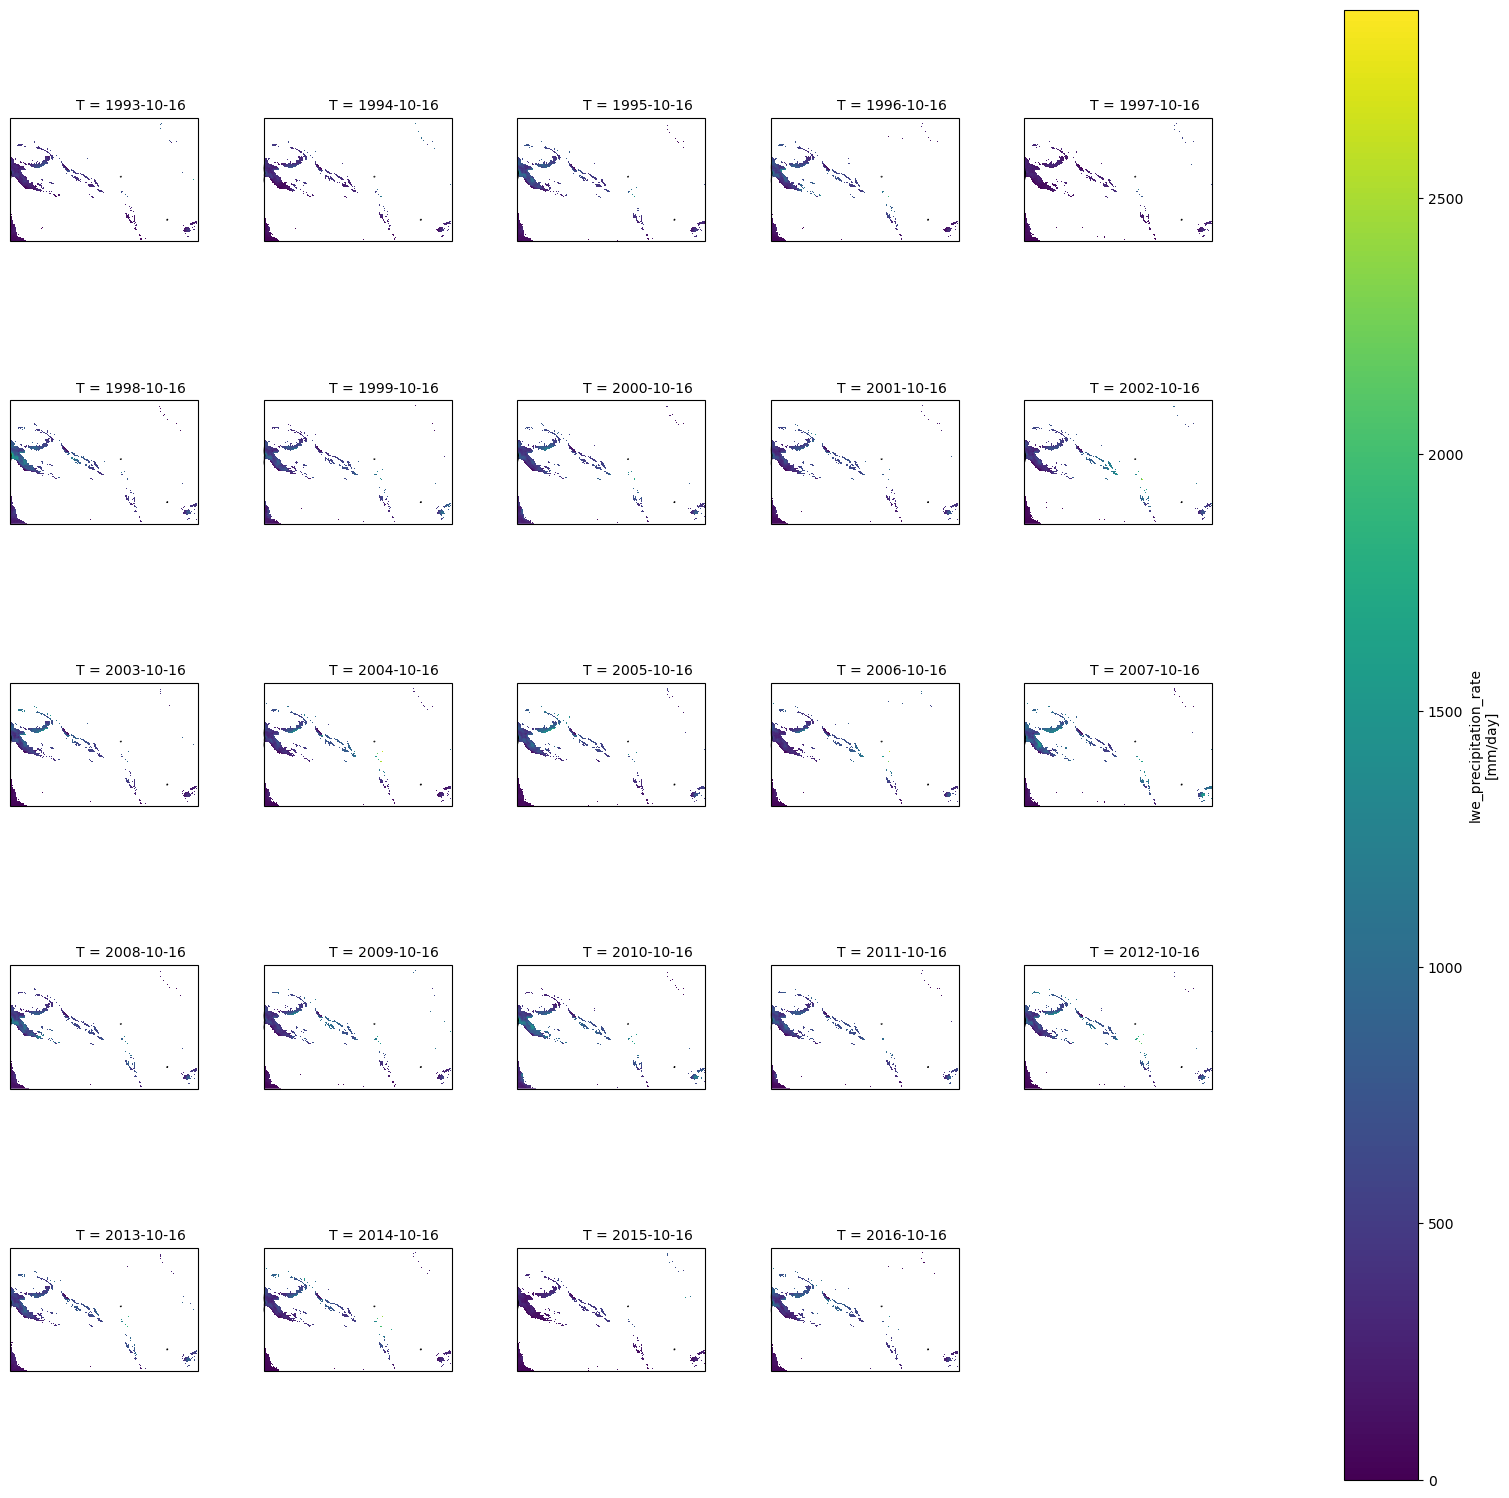

Oct-Dec_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Oct-Dec_UCSB0p05.PRCP.nc
download time is 0.07113790512084961
Nov-Jan_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Nov-Jan_UCSB0p05.PRCP.nc
download time is 0.0572206974029541
Dec-Feb_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Dec-Feb_UCSB0p05.PRCP.nc
STARTING DOWNLOAD OF Dec-Feb_UCSB0p05.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p05/.prcp/90.25/mul/T/(1%20Jan%201993)/(31%20Dec%202017)/RANGE/T/%28Dec-Feb%201993-2017%29/seasonalAverage/Y/%28-20%29/%283%29/RANGEEDGES/X/%28145%29/%28190%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv

DOWNLOADING: [*************************] (140524 KB) 0:14:50.210921

download time is 899.9042119979858


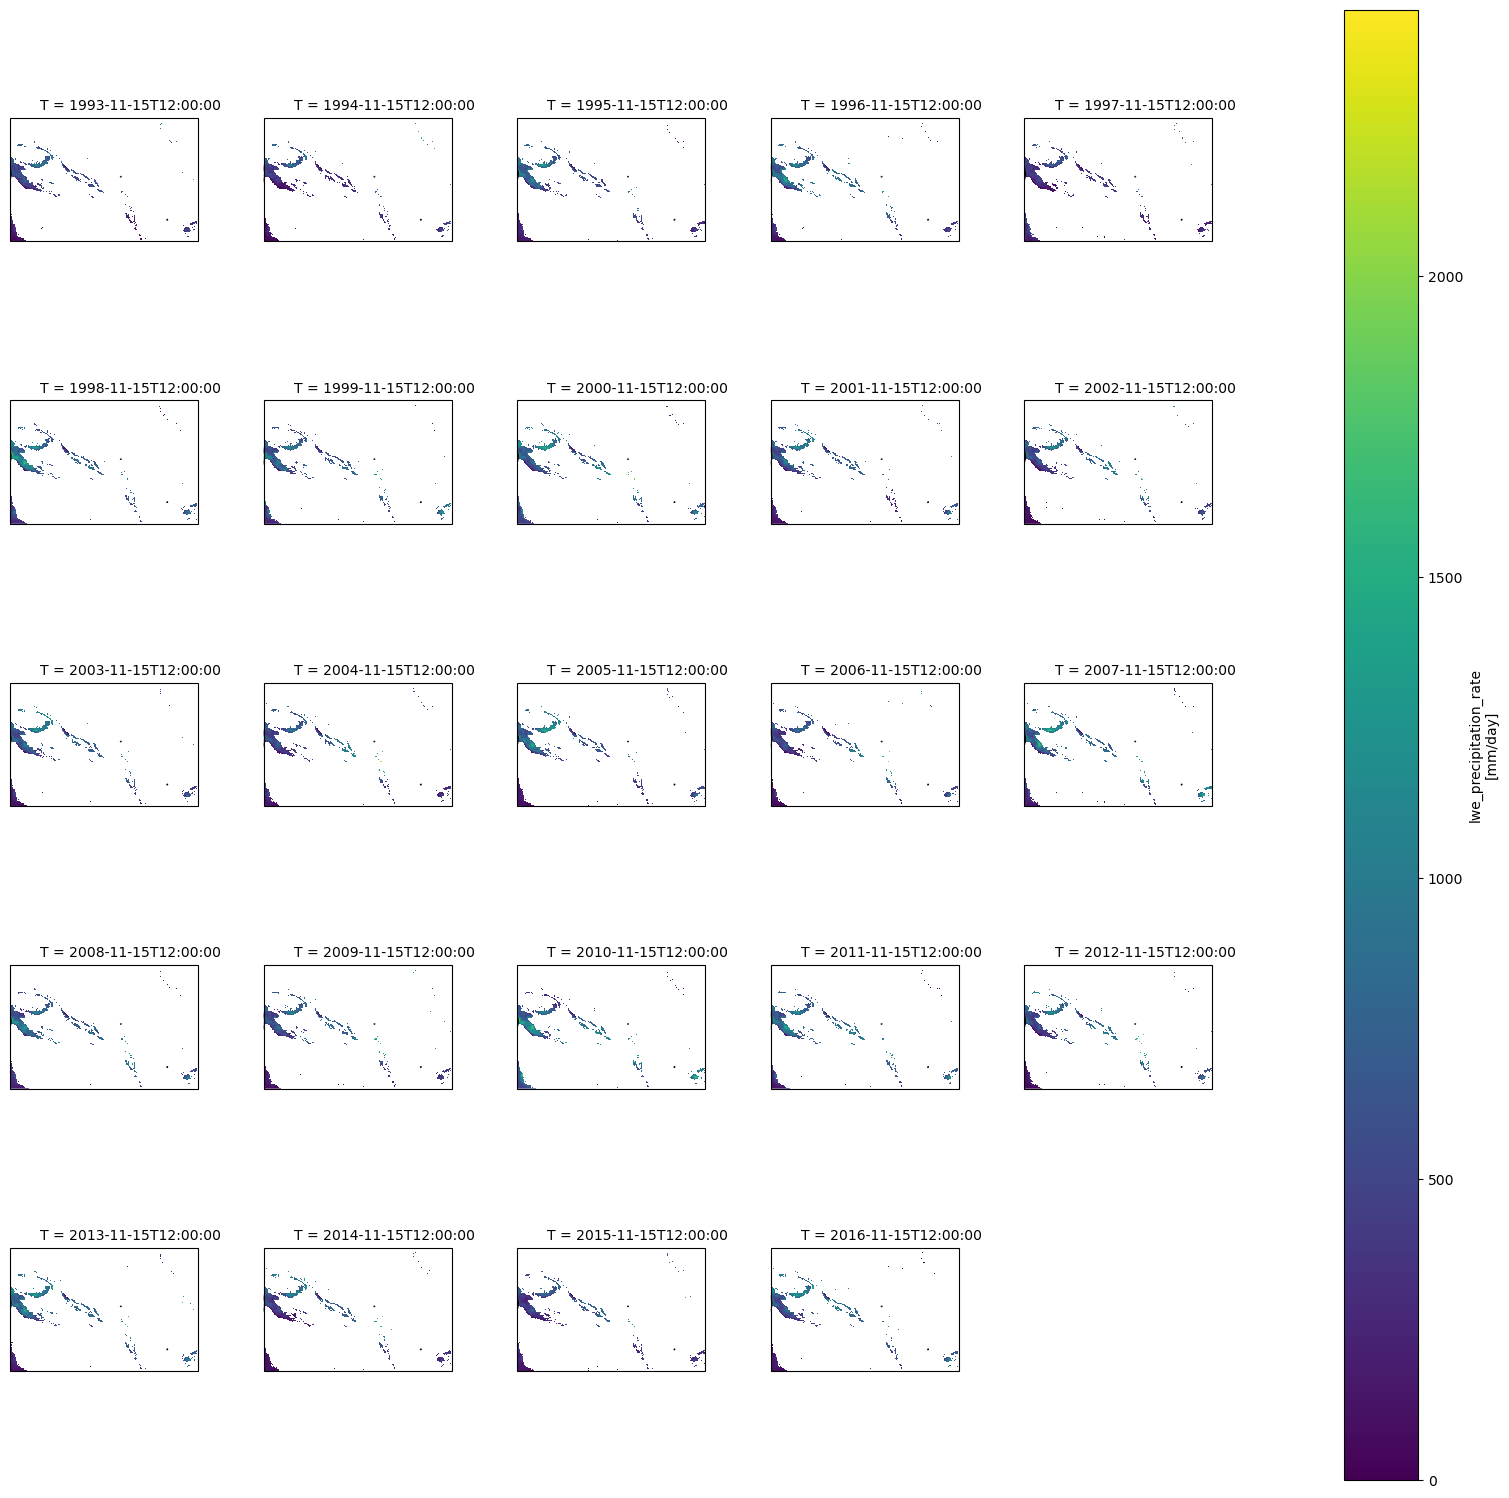

Nov-Jan_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Nov-Jan_UCSB0p05.PRCP.nc
download time is 0.05319380760192871
Dec-Feb_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Dec-Feb_UCSB0p05.PRCP.nc
download time is 0.03680419921875
Jan-Mar_UCSB0p05.PRCP
/Users/katie/Desktop/trial_pacisl/practical_data/nc_files/Jan-Mar_UCSB0p05.PRCP.nc
STARTING DOWNLOAD OF Jan-Mar_UCSB0p05.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p05/.prcp/90.25/mul/T/(1%20Jan%201993)/(31%20Dec%202017)/RANGE/T/%28Jan-Mar%201993-2017%29/seasonalAverage/Y/%28-20%29/%283%29/RANGEEDGES/X/%28145%29/%28190%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv



In [ ]:
for f in forecast_dates_of_interest:
    initial_month = dt.datetime(*f).month
    obs_leads = []
    for l, lead_low in enumerate(lead_times['lead_low']):
        start_time = time.time()
        target_low = number_to_month_name_dictionary[(initial_month + lead_low - 0.5)%12]
        target_high = number_to_month_name_dictionary[(initial_month + lead_times['lead_high'][l] - 0.5)%12]
        l_download = download_args.copy()
        l_download['target'] = '-'.join([target_low, target_high])
        l_download['lead_low'] = lead_low
        l_download['lead_high'] = lead_times['lead_high'][l]
    
        obs_download_file = '_'.join([l_download['target'], predictand_name])
        print(obs_download_file)

        print(os.path.join(nc_dir,'{}.nc'.format(obs_download_file)))
        if not Path(os.path.join(nc_dir,'{}.nc'.format(obs_download_file))).is_file():
            print('STARTING DOWNLOAD OF {}'.format(obs_download_file))
            if not Path(os.path.join(tsv_dir, '{}.tsv'.format(obs_download_file))).is_file():
                Y = dl.download(dl.observations[predictand_name], os.path.join(tsv_dir,'{}.tsv'.format(obs_download_file)), **l_download, verbose=True, use_dlauth=False)
            else:
                Y = g = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(obs_download_file)))
            Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[predictand_name]})
            Y = Y.sortby('X')
            Y.to_netcdf(os.path.join(nc_dir,'{}.nc'.format(obs_download_file)))
            print()
        else:
            Y = xr.open_dataset(os.path.join(nc_dir, '{}.nc'.format(obs_download_file)))
            Y = getattr(Y, [i for i in Y.data_vars][0])
        Y = Y.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
        print('download time is ' + str(time.time() - start_time))
        obs_leads.append(Y)
        
    #check all years are available for all lead times, only keep intersecting years
    nyears = []
    for obs in obs_leads:
        nyears.append(len(np.unique(obs.S.values)))
    if all(i==nyears[0] for i in nyears) == True:
        obs_leads = xr.concat(obs_leads, dim = 'L')
    else:
        seas_years = []
        for obs in obs_leads:
            base_obs = obs.swap_dims({'S':'Ti'}).to_dataset(name = 'prec')
            seas_years.append(np.unique(base_obs.Ti.dt.year.values))
        intersecting_years = [x for x in seas_years[0] if x in seas_years[1] and x in seas_years[2]]

        updated_obs = []
        for obs in obs_leads:
            obs_check = obs.swap_dims({'S':'Ti'}).to_dataset(name = 'prec')
            updated_obs.append(obs_check.sel(Ti=obs_check.Ti.dt.year.isin(intersecting_years)).swap_dims({'Ti':'S'}).prec)
        obs_leads = xr.concat(updated_obs, dim = 'L')

    splot = obs_leads.isel(L=0).swap_dims({'S':'T'}).plot(col = 'T', col_wrap = 5, subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)})
    for ax in  splot.axs.flat:
        coasts = ax.coastlines()
        ax.set_xlim(download_args['predictand_extent']['west'], download_args['predictand_extent']['east'])
        ax.set_ylim(download_args['predictand_extent']['south'], download_args['predictand_extent']['north'])
    plt.show()

## Download Model Data, Including Hindcasts and Forecasts

(2023, 8, 1)
STARTING DOWNLOAD OF Sep-Nov_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Aug%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/91/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2063 KB) 0:00:04.897300
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Aug%202023%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/91/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (90 KB) 0:00:01.031554

STARTING DOWNLOAD OF Sep-Nov_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu/

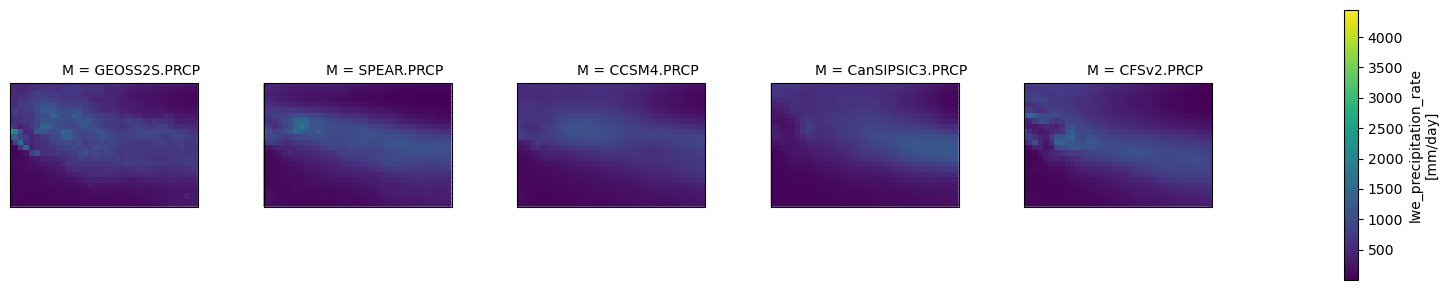

(2023, 9, 1)
STARTING DOWNLOAD OF Oct-Dec_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Sep%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2062 KB) 0:00:03.938315
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Sep%202023%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (89 KB) 0:00:00.701506

STARTING DOWNLOAD OF Oct-Dec_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu/

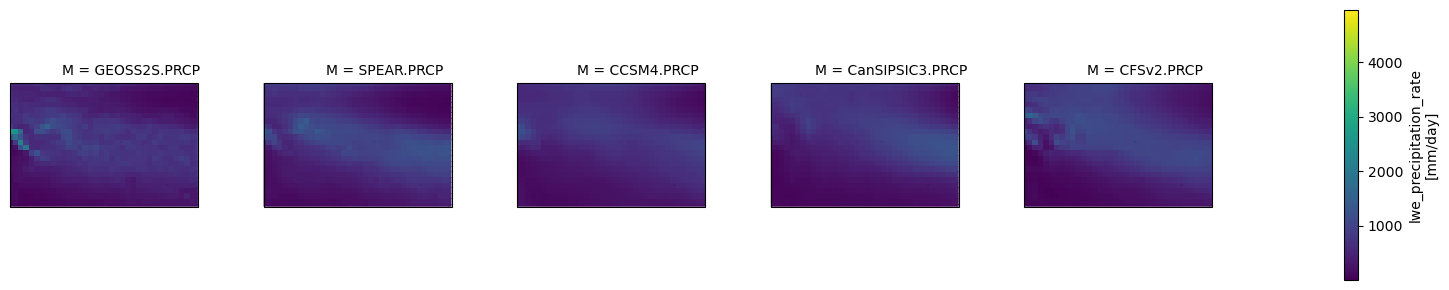

(2023, 10, 1)
STARTING DOWNLOAD OF Nov-Jan_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Oct%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2063 KB) 0:00:05.214742
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Oct%202023%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (90 KB) 0:00:00.961797

STARTING DOWNLOAD OF Nov-Jan_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu

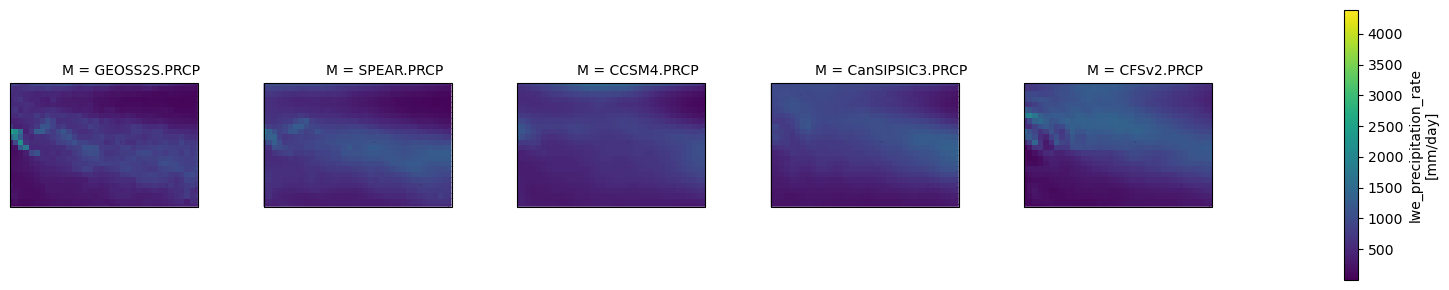

(2023, 11, 1)
STARTING DOWNLOAD OF Dec-Feb_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Nov%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/90.25/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2063 KB) 0:00:06.438604
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Nov%202023%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/90.25/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (89 KB) 0:00:00.899560

STARTING DOWNLOAD OF Dec-Feb_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columb

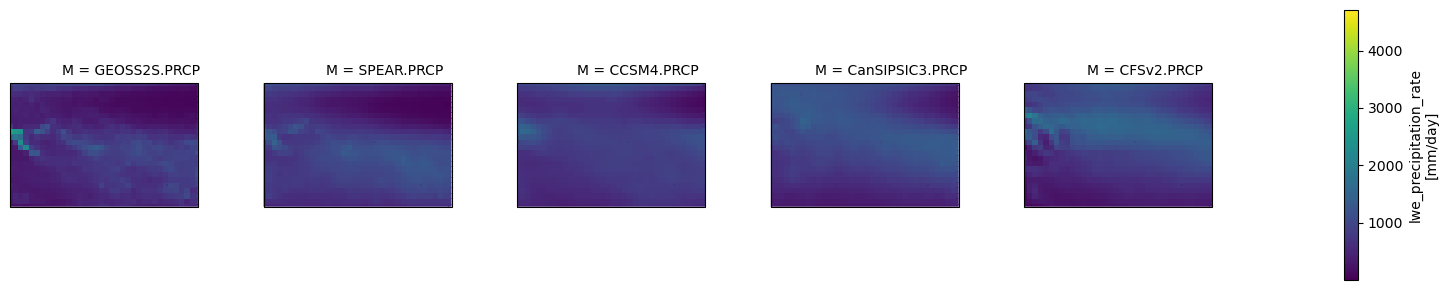

(2024, 1, 1)
STARTING DOWNLOAD OF Feb-Apr_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Jan%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/89.25/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2062 KB) 0:00:04.465924
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Jan%202024%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/89.25/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (89 KB) 0:00:01.301419

STARTING DOWNLOAD OF Feb-Apr_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbi

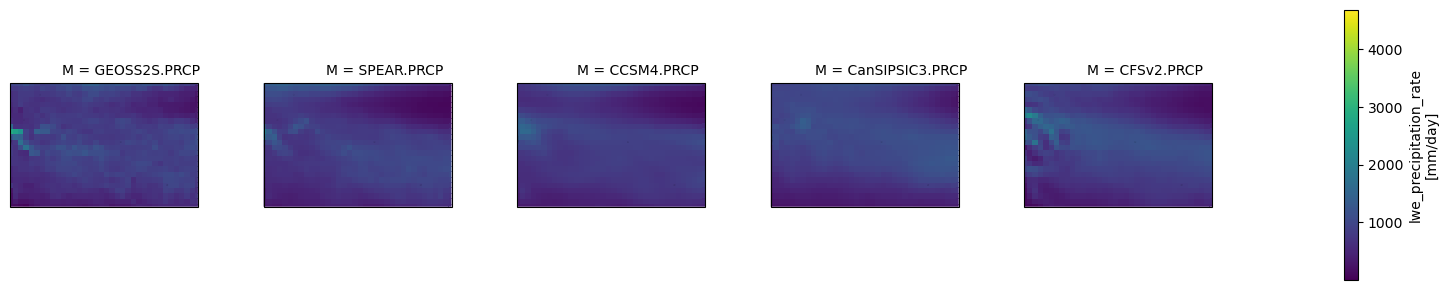

(2024, 2, 1)
STARTING DOWNLOAD OF Mar-May_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Feb%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2064 KB) 0:00:04.990720
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Feb%202024%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (90 KB) 0:00:01.029353

STARTING DOWNLOAD OF Mar-May_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu/

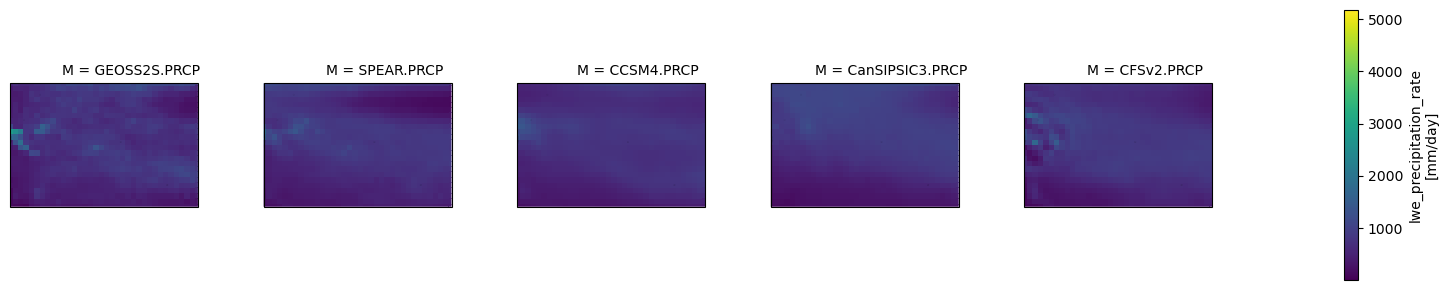

(2023, 3, 1)
STARTING DOWNLOAD OF Apr-Jun_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Mar%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/91/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2063 KB) 0:00:04.987882
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Mar%202023%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/91/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (90 KB) 0:00:00.972587

STARTING DOWNLOAD OF Apr-Jun_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu/

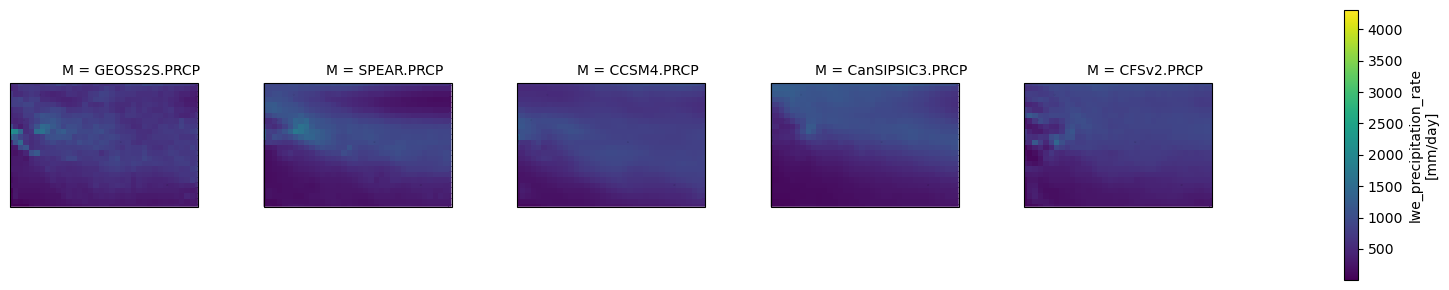

(2024, 5, 1)
STARTING DOWNLOAD OF Jun-Aug_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20May%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2065 KB) 0:00:04.983360
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20May%202024%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (91 KB) 0:00:01.174535

STARTING DOWNLOAD OF Jun-Aug_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu/

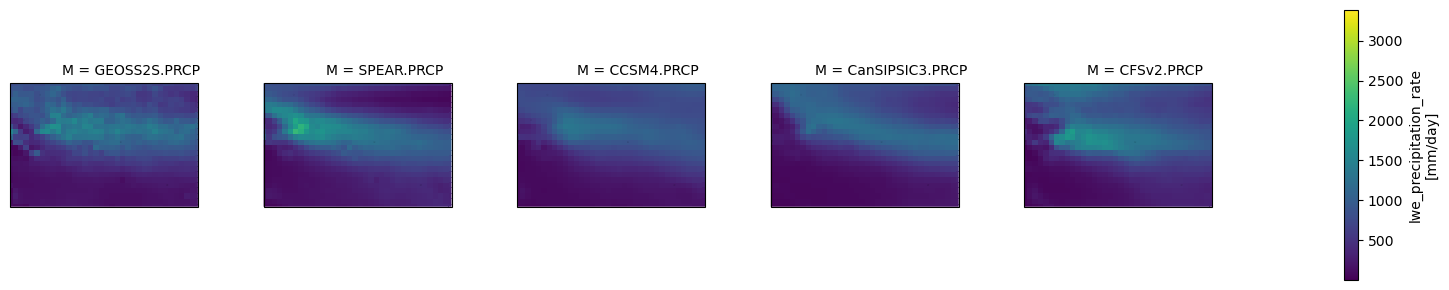

(2024, 6, 1)
STARTING DOWNLOAD OF Jul-Sep_1.5_3.5_raw_hind_GEOSS2S.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/%5BM%5D/average/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/appendstream/S/%280000%201%20Jun%201993-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (2063 KB) 0:00:04.862253
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/%5BM%5D/average/S/%280000%201%20Jun%202024%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/-30/10/RANGEEDGES/X/115/260/RANGEEDGES/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (89 KB) 0:00:00.886953

STARTING DOWNLOAD OF Jul-Sep_1.5_3.5_raw_hind_SPEAR.PRCP
URL: https://iridl.ldeo.columbia.edu/

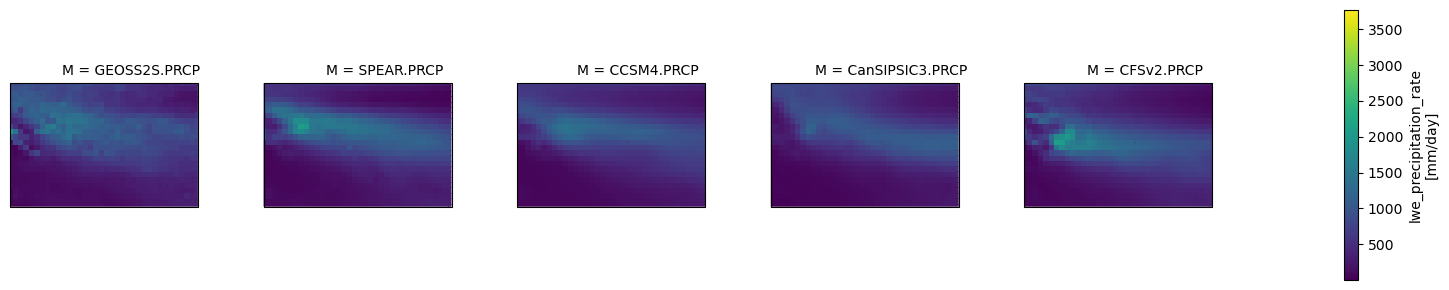

In [22]:
# Download GCMs and save raw models to netcdf
for f in forecast_dates_of_interest:
    print(f)
    iyear, imonth, iday = f # Create the datetime object for initialized data from f (stored as a tuple)
    fdate = dt.datetime(iyear, imonth, iday)
    initial_month = dt.datetime(*f).month
    hindcast_data, forecast_data = [], []
    for l, lead_low in enumerate(lead_times['lead_low']):
        target_low = number_to_month_name_dictionary[(initial_month + lead_low - 0.5)%12]
        target_high = number_to_month_name_dictionary[(initial_month + lead_times['lead_high'][l] - 0.5)%12]
        l_download = download_args.copy()
        l_download['target'] = '-'.join([target_low, target_high])
        l_download['lead_low'] = lead_low
        l_download['lead_high'] = lead_times['lead_high'][l]
        l_download['fdate'] = fdate
        hindcast_data_l, forecast_data_l = [], []
        for gcm in gcms:
            gcm_hindcast_download_file = '_'.join([l_download['target'], str(lead_low), str(l_download['lead_high']), 'raw_hind', gcm])
            gcm_forecast_download_file = '_'.join([l_download['target'], str(lead_low), str(l_download['lead_high']), 'raw_fcst', gcm])
            if not Path(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file))).is_file():
                if not Path(os.path.join(tsv_dir,'{}.tsv'.format(gcm_forecast_download_file))).is_file():
                    print('STARTING DOWNLOAD OF {}'.format(gcm_hindcast_download_file))
                    g = dl.download(dl.hindcasts[gcm], os.path.join(tsv_dir,'{}.tsv'.format(gcm_hindcast_download_file)), **l_download, verbose=True, use_dlauth=False)
                    f = dl.download(dl.forecasts[gcm], os.path.join(tsv_dir,'{}.tsv'.format(gcm_forecast_download_file)), **l_download, verbose=True, use_dlauth=False)
                    g = getattr(g, [i for i in g.data_vars][0])
                    f = getattr(f, [i for i in f.data_vars][0])
                    print()
                else:
                    print('LOADING {} FROM FILE'.format(gcm_hindcast_download_file))
                    g = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(gcm_hindcast_download_file)))
                    f = cio.open_cptdataset(os.path.join(tsv_dir, '{}.tsv'.format(gcm_forecast_download_file)))
                    print()
                    g = getattr(g, [i for i in g.data_vars][0])
                    f = getattr(f, [i for i in f.data_vars][0])
                #label datasets by model name
                g = g.expand_dims({'M':[gcm]})
                f = f.expand_dims({'M':[gcm]})

                #regrid models to observation coordinates for consistent grids across models
                #g = xc.regrid(g, Y.coords['X'].values, Y.coords['Y'].values)
                #f = xc.regrid(f, Y.coords['X'].values, Y.coords['Y'].values)

                nc_prep = xr.concat(g, 'M')
                nc_prep.to_netcdf(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file)))
                f_nc_prep = xr.concat(f, 'M')
                f_nc_prep.to_netcdf(os.path.join(nc_dir, '{}.nc'.format(gcm_forecast_download_file)))
            else:
                g = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_hindcast_download_file))).prec
                f = xr.open_dataset(os.path.join(nc_dir,'{}.nc'.format(gcm_forecast_download_file))).prec
            hindcast_data_l.append(g)
            forecast_data_l.append(f)
        hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
        forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
        hindcast_data_l = hindcast_data_l.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
        forecast_data_l = forecast_data_l.expand_dims({'L':[l+1]}).swap_dims({'T':'S'})
        hindcast_data.append(hindcast_data_l)
        forecast_data.append(forecast_data_l)

    forecast_data = xr.concat(forecast_data, dim = 'L')
    #check all hindcast years are available for all lead times
    nyears = []
    for hcsts in hindcast_data:
        nyears.append(len(np.unique(hcsts.S.values)))
    if all(i==nyears[0] for i in nyears) == True:
        hindcast_data = xr.concat(hindcast_data, dim = 'L')
    else:
        seas_years = []
        for hcst in hindcast_data:
            base_hcsts = hcst.swap_dims({'S':'Ti'}).to_dataset(name = 'prec')
            seas_years.append(np.unique(base_hcsts.Ti.dt.year.values))
        intersecting_years = [x for x in seas_years[0] if x in seas_years[1] and x in seas_years[2]]

        updated_hcsts = []
        for hcst in hindcast_data:
            hcst_check = hcst.swap_dims({'S':'Ti'}).to_dataset(name = 'prec')
            updated_hcsts.append(hcst_check.sel(Ti=hcst_check.Ti.dt.year.isin(intersecting_years)).swap_dims({'Ti':'S'}).prec)
        hindcast_data = xr.concat(updated_hcsts, dim = 'L')
    
    
    print('one month initialization')
    splot = hindcast_data.isel(L = 0).swap_dims({'S':'T'}).isel(T=0).plot(col = 'M', col_wrap = 5, subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)})
    for ax in  splot.axs.flat:
        ax.set_xlim(download_args['predictand_extent']['west'], download_args['predictand_extent']['east'])
        ax.set_ylim(download_args['predictand_extent']['south'], download_args['predictand_extent']['north'])
        ax.coastlines("10m", alpha=0.1, zorder=3)
    plt.show()